In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil

drive_data_path = '/content/drive/MyDrive/dynamic_res/imagenette2'
local_data_path = '/content/imagenette2'

if os.path.exists(local_data_path):
    shutil.rmtree(local_data_path)

shutil.copytree(drive_data_path, local_data_path)
data_path = local_data_path

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
from collections import defaultdict

import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

IMAGENETTE_CLASSES = {
    'n01440764': 'tench',
    'n02102040': 'English springer',
    'n02979186': 'cassette player',
    'n03000684': 'chain saw',
    'n03028079': 'church',
    'n03394916': 'French horn',
    'n03417042': 'garbage truck',
    'n03425413': 'gas pump',
    'n03445777': 'golf ball',
    'n03888257': 'parachute'
}

def get_readable_class_name(folder_name):
    return IMAGENETTE_CLASSES.get(folder_name, folder_name)

def evaluate_sample_predictions(model, dataset, device, batch_size=128):
    model.eval()
    sample_predictions = {}
    sample_correctness = {}
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    class IndexedDataset(torch.utils.data.Dataset):
        def __init__(self, base_dataset, transform):
            self.base_dataset = base_dataset
            self.transform = transform

        def __len__(self):
            return len(self.base_dataset)

        def __getitem__(self, idx):
            img, target = self.base_dataset.samples[idx]
            img = self.base_dataset.loader(img)
            img = self.transform(img)
            return img, target, idx

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    indexed_dataset = IndexedDataset(dataset, transform)
    loader = DataLoader(indexed_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=2, pin_memory=True)

    with torch.no_grad():
        for images, targets, indices in loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = outputs.max(1)
            for idx, pred, target in zip(indices.cpu().numpy(), predicted.cpu().numpy(), targets.cpu().numpy()):
                sample_predictions[idx] = pred
                sample_correctness[idx] = (pred == target)

    return sample_predictions, sample_correctness

def reconstruct_resolution_assignments(sample_losses, num_samples, ratio_schedule,
                                       reassign_epoch, total_epochs, mode='dynamic'):
    sample_resolutions = {i: 0 for i in range(num_samples)}
    sorted_samples = sorted(sample_losses.items(), key=lambda x: x[1])
    reassignment_count = 0
    for epoch in range(total_epochs):
        if (epoch + 1) % reassign_epoch == 0 and epoch >= reassign_epoch - 1:
            current_ratio = ratio_schedule[min(reassignment_count, len(ratio_schedule) - 1)]
            num_to_change = int(len(sorted_samples) * current_ratio)

            if mode == 'dynamic':
                samples_to_change = [idx for idx, _ in sorted_samples[:num_to_change]]
            else:
                samples_to_change = [idx for idx, _ in sorted_samples[-num_to_change:]]
            for idx in samples_to_change:
                sample_resolutions[idx] += 1

            reassignment_count += 1

    return sample_resolutions

def evaluate_sample_losses(model, dataset, device, batch_size=128):
    model.eval()
    sample_losses = {}
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    class IndexedDataset(torch.utils.data.Dataset):
        def __init__(self, base_dataset, transform):
            self.base_dataset = base_dataset
            self.transform = transform

        def __len__(self):
            return len(self.base_dataset)

        def __getitem__(self, idx):
            img, target = self.base_dataset.samples[idx]
            img = self.base_dataset.loader(img)
            img = self.transform(img)
            return img, target, idx

    transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), normalize])

    indexed_dataset = IndexedDataset(dataset, transform)
    loader = DataLoader(indexed_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    criterion = nn.CrossEntropyLoss(reduction='none')

    with torch.no_grad():
        for images, targets, indices in loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            outputs = model(images)
            losses = criterion(outputs, targets)

            for idx, loss in zip(indices.cpu().numpy(), losses.cpu().numpy()):
                sample_losses[idx] = loss

    return sample_losses

def compute_resolution_schedule(r_max, r_min, gamma):
    schedule = []
    r = r_max

    while True:
        schedule.append(r)
        r_next = int(r * gamma)
        r_next = max(r_next, r_min)

        if r_next == r:
            break

        r = r_next

    return schedule

def compute_inverted_resolution_schedule(r_start, r_max, gamma):
    schedule = []
    r = r_start

    while True:
        schedule.append(r)
        r_next = int(r * gamma)
        r_next = min(r_next, r_max)

        if r_next == r:
            break

        r = r_next

    return schedule

def compute_ratio_overlap(sample_losses, num_samples, ratio1, ratio2,
                          reassign_epoch, total_epochs, mode='dynamic'):
    sorted_samples = sorted(sample_losses.items(), key=lambda x: x[1])
    reassignment_count = 0
    selected_at_ratio1 = set()
    selected_at_ratio2 = set()

    for epoch in range(total_epochs):
        if (epoch + 1) % reassign_epoch == 0 and epoch >= reassign_epoch - 1:
            if reassignment_count == 0:
                num_to_change_1 = int(len(sorted_samples) * ratio1)
                num_to_change_2 = int(len(sorted_samples) * ratio2)

                if mode == 'dynamic':
                    selected_at_ratio1 = set([idx for idx, _ in sorted_samples[:num_to_change_1]])
                    selected_at_ratio2 = set([idx for idx, _ in sorted_samples[:num_to_change_2]])
                else:
                    selected_at_ratio1 = set([idx for idx, _ in sorted_samples[-num_to_change_1:]])
                    selected_at_ratio2 = set([idx for idx, _ in sorted_samples[-num_to_change_2:]])

                break
            reassignment_count += 1

    overlap = selected_at_ratio1.intersection(selected_at_ratio2)
    only_ratio1 = selected_at_ratio1 - selected_at_ratio2
    only_ratio2 = selected_at_ratio2 - selected_at_ratio1
    overlap_pct = (len(overlap) / len(selected_at_ratio1)) * 100 if len(selected_at_ratio1) > 0 else 0

    results = {
        'ratio1': ratio1,
        'ratio2': ratio2,
        'selected_at_ratio1': len(selected_at_ratio1),
        'selected_at_ratio2': len(selected_at_ratio2),
        'overlap_count': len(overlap),
        'overlap_percentage': overlap_pct,
        'only_ratio1_count': len(only_ratio1),
        'only_ratio2_count': len(only_ratio2),
        'overlap_ids': sorted(list(overlap)),
        'only_ratio1_ids': sorted(list(only_ratio1)),
        'only_ratio2_ids': sorted(list(only_ratio2))
    }
    return results

In [3]:
model_dir = '/content/drive/MyDrive/dynamic_res'
model_dynamic_path = f'{model_dir}/model_dynamic.pth'
model_inverted_path = f'{model_dir}/model_inverted.pth'

arch = 'resnet18'
epochs = 30
reassign_epoch = 10
ratio_schedule_dynamic = '0.4,0.5'
ratio_schedule_inverted = '0.4,0.5'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

traindir = os.path.join(data_path, 'train')
dataset = datasets.ImageFolder(traindir)

num_samples = len(dataset)
class_labels = [label for _, label in dataset.samples]
class_names = dataset.classes

In [4]:
model = models.__dict__[arch](num_classes=10)
model.load_state_dict(torch.load(model_dynamic_path, map_location=device))
model = model.to(device)

sample_losses_dynamic = evaluate_sample_losses(model, dataset, device)

ratio_schedule = [float(x) for x in ratio_schedule_dynamic.split(',')]
resolution_schedule_dynamic = compute_resolution_schedule(224, 112, 0.5)

sample_resolutions_dynamic = reconstruct_resolution_assignments(sample_losses_dynamic, num_samples, ratio_schedule, reassign_epoch, epochs, mode='dynamic')

In [5]:
model = models.__dict__[arch](num_classes=10)
model.load_state_dict(torch.load(model_inverted_path, map_location=device))
model = model.to(device)

sample_losses_inverted = evaluate_sample_losses(model, dataset, device)

ratio_schedule = [float(x) for x in ratio_schedule_inverted.split(',')]
resolution_schedule_inverted = compute_inverted_resolution_schedule(112, 224, 2.0)

sample_resolutions_inverted = reconstruct_resolution_assignments(sample_losses_inverted, num_samples, ratio_schedule, reassign_epoch, epochs, mode='inverted')

In [6]:
class_analysis = {}
for class_idx in sorted(set(class_labels)):
    folder_name = class_names[class_idx]
    readable_name = get_readable_class_name(folder_name)

    dynamic_112 = sum(1 for idx, label in enumerate(class_labels)
                      if label == class_idx and sample_resolutions_dynamic[idx] > 0)
    dynamic_224 = sum(1 for idx, label in enumerate(class_labels)
                      if label == class_idx and sample_resolutions_dynamic[idx] == 0)

    inverted_224 = sum(1 for idx, label in enumerate(class_labels)
                       if label == class_idx and sample_resolutions_inverted[idx] > 0)
    inverted_112 = sum(1 for idx, label in enumerate(class_labels)
                       if label == class_idx and sample_resolutions_inverted[idx] == 0)

    total_samples = sum(1 for label in class_labels if label == class_idx)

    class_analysis[class_idx] = {
        'name': readable_name,
        'folder': folder_name,
        'total': total_samples,
        'dynamic_112': dynamic_112,
        'dynamic_224': dynamic_224,
        'inverted_224': inverted_224,
        'inverted_112': inverted_112
    }

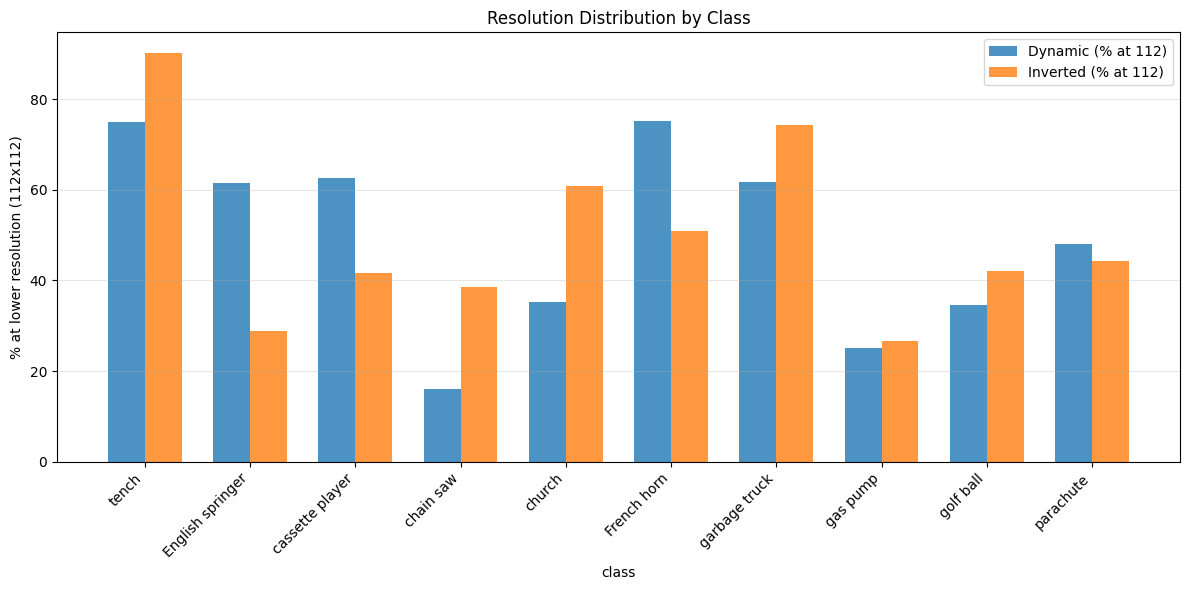

In [11]:
import matplotlib.pyplot as plt

class_names_list = [class_analysis[idx]['name'] for idx in sorted(class_analysis.keys())]
dynamic_low_res_pct = [(class_analysis[idx]['dynamic_112'] / class_analysis[idx]['total']) * 100 for idx in sorted(class_analysis.keys())]
inverted_low_res_pct = [(class_analysis[idx]['inverted_112'] / class_analysis[idx]['total']) * 100 for idx in sorted(class_analysis.keys())]

x = np.arange(len(class_names_list))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, dynamic_low_res_pct, width, label='Dynamic (% at 112)', alpha=0.8)
bars2 = ax.bar(x + width/2, inverted_low_res_pct, width, label='Inverted (% at 112)', alpha=0.8)

ax.set_xlabel('class')
ax.set_ylabel('% at lower resolution (112x112)')
ax.set_title('Resolution Distribution by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names_list, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
overlap_dynamic = compute_ratio_overlap(sample_losses_dynamic, num_samples, 0.4, 0.5, reassign_epoch, epochs, mode='dynamic')

overlap_inverted = compute_ratio_overlap(sample_losses_inverted, num_samples, 0.4, 0.5, reassign_epoch, epochs, mode='inverted')

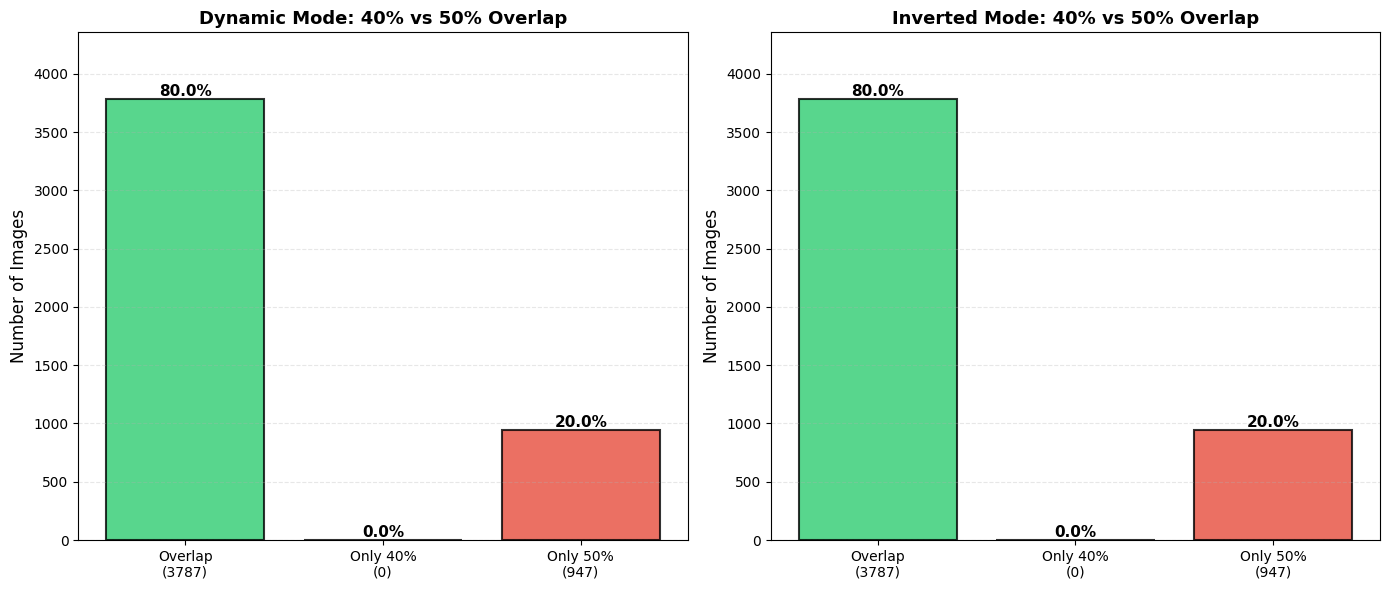

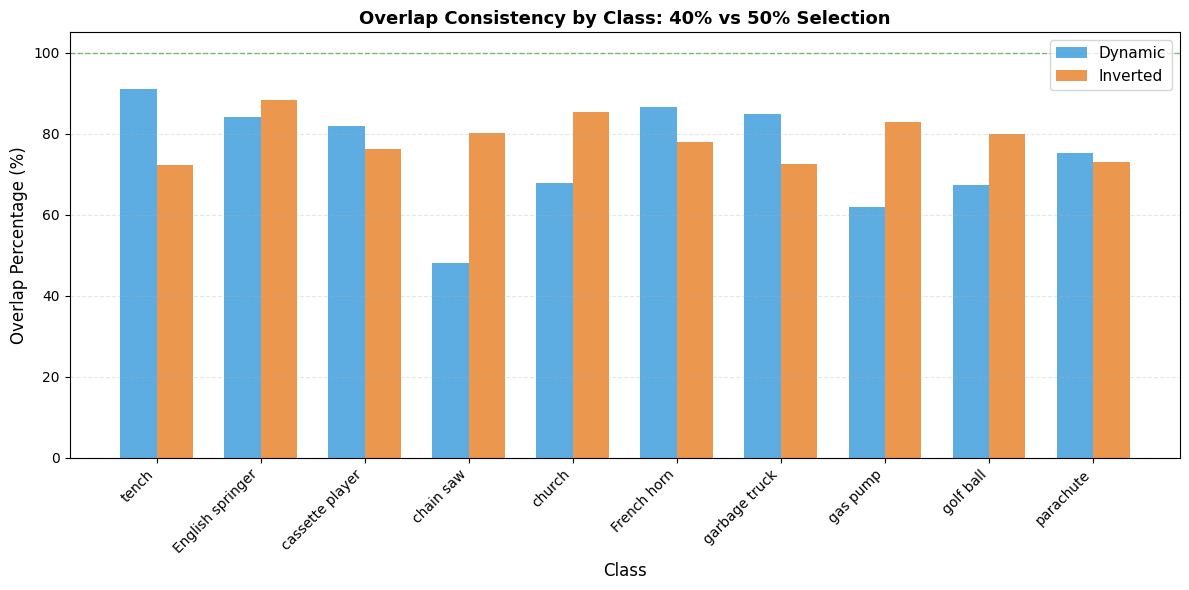

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

modes = ['Dynamic', 'Inverted']
overlaps = [overlap_dynamic, overlap_inverted]

for idx, (mode, overlap_data) in enumerate(zip(modes, overlaps)):
    ax = ax1 if idx == 0 else ax2

    categories = [
        f'Overlap\n({overlap_data["overlap_count"]})',
        f'Only 40%\n({overlap_data["only_ratio1_count"]})',
        f'Only 50%\n({overlap_data["only_ratio2_count"]})'
    ]
    counts = [
        overlap_data['overlap_count'],
        overlap_data['only_ratio1_count'],
        overlap_data['only_ratio2_count']
    ]
    colors = ['#2ecc71', '#3498db', '#e74c3c']

    bars = ax.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        pct = (count / overlap_data['selected_at_ratio2']) * 100
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax.set_ylabel('Number of Images', fontsize=12)
    ax.set_title(f'{mode} Mode: 40% vs 50% Overlap', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, max(counts) * 1.15)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

class_to_samples = defaultdict(list)
for idx, class_idx in enumerate(class_labels):
    class_to_samples[class_idx].append(idx)

class_names_list = []
dynamic_overlap_pct = []
inverted_overlap_pct = []

for class_idx in sorted(class_to_samples.keys()):
    folder_name = class_names[class_idx]
    readable_name = get_readable_class_name(folder_name)
    class_names_list.append(readable_name)

    class_samples = set(class_to_samples[class_idx])

    dynamic_overlap_count = len(class_samples.intersection(overlap_dynamic['overlap_ids']))
    dynamic_selected = len(class_samples.intersection(
        set(overlap_dynamic['overlap_ids']) |
        set(overlap_dynamic['only_ratio1_ids']) |
        set(overlap_dynamic['only_ratio2_ids'])
    ))
    dynamic_pct = (dynamic_overlap_count / dynamic_selected * 100) if dynamic_selected > 0 else 0

    inverted_overlap_count = len(class_samples.intersection(overlap_inverted['overlap_ids']))
    inverted_selected = len(class_samples.intersection(
        set(overlap_inverted['overlap_ids']) |
        set(overlap_inverted['only_ratio1_ids']) |
        set(overlap_inverted['only_ratio2_ids'])
    ))
    inverted_pct = (inverted_overlap_count / inverted_selected * 100) if inverted_selected > 0 else 0

    dynamic_overlap_pct.append(dynamic_pct)
    inverted_overlap_pct.append(inverted_pct)

x = np.arange(len(class_names_list))
width = 0.35

bars1 = ax.bar(x - width/2, dynamic_overlap_pct, width, label='Dynamic', alpha=0.8, color='#3498db')
bars2 = ax.bar(x + width/2, inverted_overlap_pct, width, label='Inverted', alpha=0.8, color='#e67e22')

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Overlap Percentage (%)', fontsize=12)
ax.set_title('Overlap Consistency by Class: 40% vs 50% Selection', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names_list, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, linewidth=1, label='100% overlap')

plt.tight_layout()
plt.show()

In [10]:
testdir = os.path.join(data_path, 'val')
test_dataset = datasets.ImageFolder(testdir)
test_class_labels = [label for _, label in test_dataset.samples]
test_class_names = test_dataset.classes

model_baseline_path = f'{model_dir}/model_baseline.pth'
model = models.__dict__[arch](num_classes=10)
model.load_state_dict(torch.load(model_baseline_path, map_location=device))
model = model.to(device)
_, sample_correctness_baseline_test = evaluate_sample_predictions(model, test_dataset, device)

model = models.__dict__[arch](num_classes=10)
model.load_state_dict(torch.load(model_dynamic_path, map_location=device))
model = model.to(device)
_, sample_correctness_dynamic_test = evaluate_sample_predictions(model, test_dataset, device)

model = models.__dict__[arch](num_classes=10)
model.load_state_dict(torch.load(model_inverted_path, map_location=device))
model = model.to(device)
_, sample_correctness_inverted_test = evaluate_sample_predictions(model, test_dataset, device)